<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Assignment2/Assignment2_Project2_offensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 4.5MB/s 
     |████████████████████████████████| 901kB 17.5MB/s 
     |████████████████████████████████| 3.3MB 50.1MB/s 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import requests
import re
import string
import math
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Load the data

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# Experiment focus on hate, irony and offensive
# Both 3 tasks can be run on the same code by alternating the "task" parameter below
# Other tasks have not been tested and may occur errors
task='offensive'
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt", allow_redirects=True)
open('test_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt", allow_redirects=True)
open('test_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_labels.txt", allow_redirects=True)
open('train_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_text.txt", allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_labels.txt", allow_redirects=True)
open('val_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_text.txt", allow_redirects=True)
open('val_text.txt', 'wb').write(r.content)

file = open('test_labels.txt')
test_labels = file.readlines()
file.close
file = open('test_text.txt')
test_text = file.readlines()
file.close
file = open('train_labels.txt')
train_labels = file.readlines()
file.close
file = open('train_text.txt')
train_text = file.readlines()
file.close
file = open('val_labels.txt')
val_labels = file.readlines()
file.close
file = open('val_text.txt')
val_text = file.readlines()
file.close

print("Number of total data:        ", len(train_labels)+len(val_labels)+len(test_labels))
print("Number of train labels:      ", len(train_labels))
print("Number of train text:        ", len(train_text))
print("Number of validation labels: ", len(val_labels))
print("Number of validation text:   ", len(val_text))
print("Number of test labels:       ", len(test_labels))
print("Number of test text:         ", len(test_text))

Number of total data:         14100
Number of train labels:       11916
Number of train text:         11916
Number of validation labels:  1324
Number of validation text:    1324
Number of test labels:        860
Number of test text:          860


In [ ]:
# Create subset from the dataset for system development
#test_labels = val_labels[:]
#test_text = val_text[:]
#train_labels = train_labels[500:2500]
#train_text = train_text[500:2500]
#val_labels = val_labels[:100]
#val_text = val_text[:100]

In [ ]:
# Download label mapping
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
class_labels = [row[1] for row in csvreader if len(row) > 1]
print('Labels:', class_labels)

Labels: ['not-offensive', 'offensive']


In [ ]:
df = pd.DataFrame(data={'label': train_labels + val_labels + test_labels, 'text': train_text + val_text + test_text})
df

,label,text
0,0\n,@user Bono... who cares. Soon people will unde...
1,1\n,@user Eight years the republicans denied obama...
2,0\n,@user Get him some line help. He is gonna be j...
3,0\n,@user @user She is great. Hi Fiona! \n
4,1\n,@user She has become a parody unto herself? Sh...
...,...,...
14095,0\n,#CNN irrationally argues 4 legalising #abortio...
14096,0\n,@user @user @user @user @user @user @user @use...
14097,1\n,#Conservatives don’t care what you post..it’s ...
14098,0\n,#antifa #Resist.. Trump is trying to bring wor...


In [ ]:
df['length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df

,label,text,length
0,0\n,@user Bono... who cares. Soon people will unde...,36
1,1\n,@user Eight years the republicans denied obama...,22
2,0\n,@user Get him some line help. He is gonna be j...,51
3,0\n,@user @user She is great. Hi Fiona! \n,11
4,1\n,@user She has become a parody unto herself? Sh...,39
...,...,...,...
14095,0\n,#CNN irrationally argues 4 legalising #abortio...,50
14096,0\n,@user @user @user @user @user @user @user @use...,62
14097,1\n,#Conservatives don’t care what you post..it’s ...,14
14098,0\n,#antifa #Resist.. Trump is trying to bring wor...,30


In [ ]:
np.mean(df['length'][:len(train_text)].tolist())

28.231537428667338

  label  counts
0   0\n    9460
1   1\n    4640


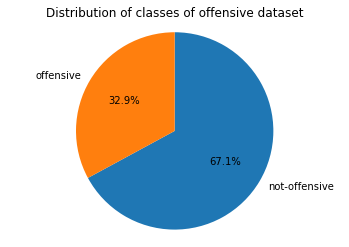

In [ ]:
# Show distribution of classes
df_class = df.groupby('label').size().reset_index(name='counts')
print(df_class)

labels = class_labels
sizes = df_class['counts'].tolist()
plt.title(f"Distribution of classes of {task} dataset")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

# Pre-processing

In [ ]:
# Cleaning the data
df['label'] = df['label'].apply(lambda x: re.sub('\n','', x))
df['text'] = df['text'].apply(lambda x: re.sub('\n','', x))
# Lowercase the words
df['cleaned'] = df['text'].apply(lambda x: x.lower())
# Remove digits and words containing digits
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Remove Punctuations
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Remove extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Remove stop words
stop_words = set(nltk.corpus.stopwords.words("english"))
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stop words removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# Remove stop words again
df['lemmatized'] = df['lemmatized'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

df

CPU times: user 43min 29s, sys: 19.2 s, total: 43min 48s
Wall time: 43min 56s


# Experiment

In [ ]:
df['lemmatized'] = df['lemmatized'].astype(str)
train_text_list = df['lemmatized'][:len(train_text)].tolist()
val_text_list = df['lemmatized'][len(train_text):len(train_text) + len(val_text)].tolist()
test_text_list = df['lemmatized'][len(train_text) + len(val_text):].tolist()

df['label'] = df['label'].astype(int)
train_label_list = df['label'][:len(train_text)].tolist()
val_label_list = df['label'][len(train_text):len(train_text) + len(val_text)].tolist()
test_label_list = df['label'][len(train_text) + len(val_text):].tolist()

In [ ]:
%%time
# Creating feature vector
# Most frequently 3000 word is selected as the features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=3000)

# Only training set will be used to obtain features
train_set_vector = vectorizer.fit_transform(train_text_list)
val_set_vector = vectorizer.transform(val_text_list)
test_set_vector = vectorizer.transform(test_text_list)

train_set_label = [label for label in train_label_list]
val_set_label = [label for label in val_label_list]
test_set_label = [label for label in test_label_list]

CPU times: user 219 ms, sys: 4 ms, total: 223 ms
Wall time: 230 ms


In [ ]:
%%time
# Creating feature tensor
# Most frequently 3000 word is selected as the features
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_features = 3000
maxlen = 30
tokenizer = Tokenizer(num_words=3000)

# Only training set will be used to obtain features
tokenizer.fit_on_texts(train_text_list)

train_set_content = tokenizer.texts_to_sequences(train_text_list)
train_set_content = sequence.pad_sequences(train_set_content, maxlen=maxlen)
val_set_content = tokenizer.texts_to_sequences(val_text_list)
val_set_content = sequence.pad_sequences(val_set_content, maxlen=maxlen)
test_set_content = tokenizer.texts_to_sequences(test_text_list)
test_set_content = sequence.pad_sequences(test_set_content, maxlen=maxlen)

CPU times: user 523 ms, sys: 13 ms, total: 536 ms
Wall time: 571 ms


In [ ]:
import seaborn as sn
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier

# Conventional

In [ ]:
%%time
# Dummy (majority) is used as the classification model
Dummyclf = DummyClassifier(strategy='most_frequent')
# Train Dummy Classifier
Dummyclf = Dummyclf.fit(train_set_vector, train_set_label)

CPU times: user 2.59 ms, sys: 5 µs, total: 2.6 ms
Wall time: 3.15 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = Dummyclf.predict(test_set_vector)

CPU times: user 230 µs, sys: 2 µs, total: 232 µs
Wall time: 216 µs


Majority:
Accuracy Score: 0.7209302325581395
Macro F1 Score: 0.4189189189189189
Clasification report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84       620
           1       0.00      0.00      0.00       240

    accuracy                           0.72       860
   macro avg       0.36      0.50      0.42       860
weighted avg       0.52      0.72      0.60       860



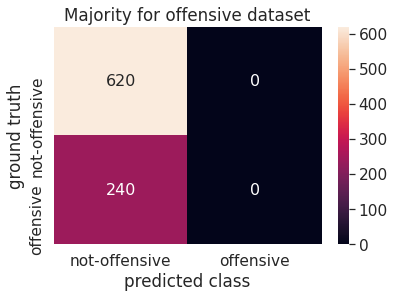

In [ ]:
print("Majority:")
#print('Best parameters: ', Dummyclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label, zero_division=0))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Majority for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Naive Bayes Classifier is used as the classification model
NBclf = MultinomialNB(alpha=1.0, fit_prior=True)
param_grid = {
    # 'fit_prior' : [True, False],
}
NBclf = GridSearchCV(estimator=NBclf, param_grid=param_grid, n_jobs=-1)
# Train Naive Bayes Classifier
NBclf = NBclf.fit(train_set_vector, train_set_label)

CPU times: user 251 ms, sys: 56.9 ms, total: 308 ms
Wall time: 1.26 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = NBclf.predict(test_set_vector)

CPU times: user 2.07 ms, sys: 8 µs, total: 2.07 ms
Wall time: 2.05 ms


Naive Bayes:
Best parameters:  {}
Accuracy Score: 0.7744186046511627
Macro F1 Score: 0.7277699456975774
Clasification report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       620
           1       0.59      0.65      0.62       240

    accuracy                           0.77       860
   macro avg       0.72      0.74      0.73       860
weighted avg       0.78      0.77      0.78       860



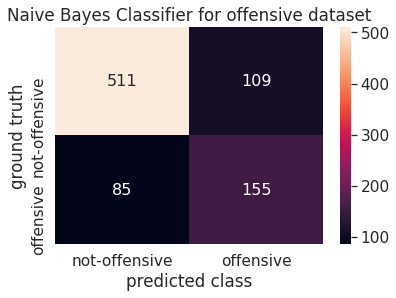

In [ ]:
print("Naive Bayes:")
print('Best parameters: ', NBclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Naive Bayes Classifier for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Decision Tree is used as the classification model
DTclf = DecisionTreeClassifier(criterion="entropy", min_samples_split=10)
param_grid = {
    # 'criterion' : ["entropy", "gini"],
    # 'max_depth' : np.arange(10, 21, 1),
    # 'min_samples_split' : np.arange(10, 21, 1),
}
DTclf = GridSearchCV(estimator=DTclf, param_grid=param_grid, n_jobs=-1)
# Train Decision Tree Classifier
DTclf = DTclf.fit(train_set_vector, train_set_label)

CPU times: user 1.69 s, sys: 12 ms, total: 1.7 s
Wall time: 6.19 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = DTclf.predict(test_set_vector)

CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 1.96 ms


Decision Tree:
Best parameters:  {}
Accuracy Score: 0.7372093023255814
Macro F1 Score: 0.6835991170207917
Clasification report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       620
           1       0.53      0.58      0.55       240

    accuracy                           0.74       860
   macro avg       0.68      0.69      0.68       860
weighted avg       0.75      0.74      0.74       860



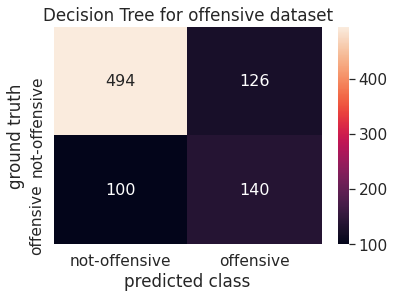

In [ ]:
print("Decision Tree:")
print('Best parameters: ', DTclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Decision Tree for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# K-Nearest Neighbors is used as the classification model
KNNclf = KNeighborsClassifier(weights="distance", p = 2, n_neighbors=5) #euclidean distance
param_grid = {
        #'n_neighbors': np.arange(1, 11, 1),
        #'weights': ["uniform", "distance"],
}
KNNclf = GridSearchCV(estimator=KNNclf, param_grid=param_grid, n_jobs=-1)
# Train K-Nearest Neighbors Classifier
KNNclf = KNNclf.fit(train_set_vector, train_set_label)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 255 ms, sys: 49 ms, total: 304 ms
Wall time: 4.35 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = KNNclf.predict(test_set_vector)

CPU times: user 262 ms, sys: 89 ms, total: 351 ms
Wall time: 349 ms


K-Nearest Neighbors:
Best parameters:  {}
Accuracy Score: 0.7569767441860465
Macro F1 Score: 0.6108437204327615
Clasification report:
               precision    recall  f1-score   support

           0       0.77      0.95      0.85       620
           1       0.67      0.26      0.37       240

    accuracy                           0.76       860
   macro avg       0.72      0.60      0.61       860
weighted avg       0.74      0.76      0.72       860



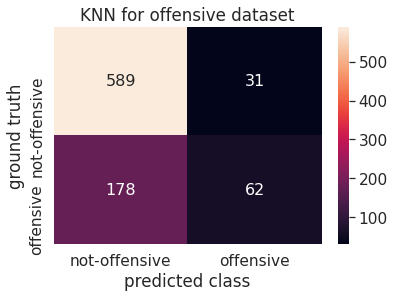

In [ ]:
print("K-Nearest Neighbors:")
print('Best parameters: ', KNNclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"KNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Support Vector Machine is used as the classification model
SVMclf = SVC(kernel='rbf', C=1, gamma=0.1)
param_grid = {
    #'kernel': ["linear", "poly", "rbf"],
    #'C' : np.logspace(-1, 3, 5),
    #'gamma' : np.logspace(-4, -0, 5),
}
SVMclf = GridSearchCV(estimator=SVMclf, param_grid=param_grid, n_jobs=-1)
# Train Support Vector Machine Classifier
SVMclf = SVMclf.fit(train_set_vector, train_set_label)

CPU times: user 24.2 s, sys: 157 ms, total: 24.4 s
Wall time: 1min 12s


In [ ]:
%%time
# Predict using test dataset
predicted_label = SVMclf.predict(test_set_vector)

CPU times: user 848 ms, sys: 1.98 ms, total: 850 ms
Wall time: 848 ms


Support Vector Machine:
Best parameters:  {}
Accuracy Score: 0.8011627906976744
Macro F1 Score: 0.6786550097347472
Clasification report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88       620
           1       0.89      0.33      0.48       240

    accuracy                           0.80       860
   macro avg       0.84      0.66      0.68       860
weighted avg       0.82      0.80      0.77       860



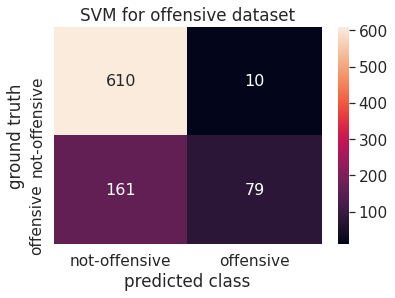

In [ ]:
print("Support Vector Machine:")
print('Best parameters: ', SVMclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SVM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

# Deep Learning

In [ ]:
%%time
# SimpleANN is used as the classification model
model = models.Sequential()
model.add(Dense(32, input_shape=(30,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleANN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 1s 5ms/step - loss: 60.4244 - acc: 0.5458 - val_loss: 8.3166 - val_acc: 0.6390
Epoch 2/5
94/94 [==============================] - 0s 2ms/step - loss: 7.4611 - acc: 0.5763 - val_loss: 13.5927 - val_acc: 0.6526
Epoch 3/5
94/94 [==============================] - 0s 2ms/step - loss: 7.1346 - acc: 0.5891 - val_loss: 8.8069 - val_acc: 0.3822
Epoch 4/5
94/94 [==============================] - 0s 2ms/step - loss: 6.9738 - acc: 0.5605 - val_loss: 4.6602 - val_acc: 0.554

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 129 ms, sys: 2.03 ms, total: 131 ms
Wall time: 134 ms


SimpleANN:
Accuracy Score: 0.4662790697674419
Macro F1 Score: 0.459963800583076
Clasification report:
               precision    recall  f1-score   support

           0       0.74      0.40      0.52       620
           1       0.29      0.64      0.40       240

    accuracy                           0.47       860
   macro avg       0.52      0.52      0.46       860
weighted avg       0.62      0.47      0.49       860



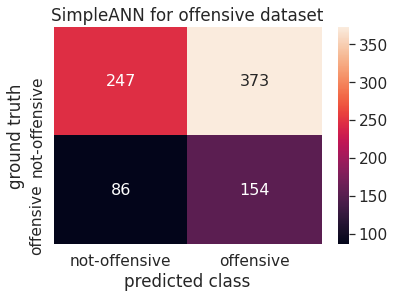

In [ ]:
print("SimpleANN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleANN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# SimpleRNN is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleRNN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          96000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 98,113
Trainable params: 98,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6332 - acc: 0.6636 - val_loss: 0.6216 - val_acc: 0.6994
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 0.5436 - acc: 0.7402 - val_loss: 0.5468 - val_

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 233 ms, sys: 8.05 ms, total: 241 ms
Wall time: 218 ms


SimpleRNN:
Accuracy Score: 0.791860465116279
Macro F1 Score: 0.6899814923341208
Clasification report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87       620
           1       0.74      0.39      0.51       240

    accuracy                           0.79       860
   macro avg       0.77      0.67      0.69       860
weighted avg       0.78      0.79      0.77       860



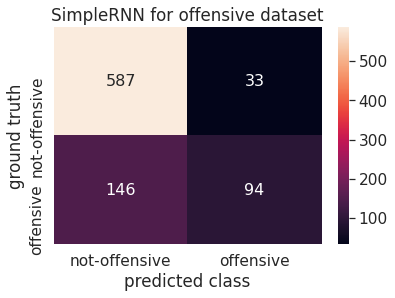

In [ ]:
print("SimpleRNN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleRNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 5s 30ms/step - loss: 0.6428 - acc: 0.6530 - val_loss: 0.6997 - val_acc: 0.6533
Epoch 2/5
94/94 [==============================] - 2s 26ms/step - loss: 0.5753 - acc: 0.6863 - val_loss: 0.5419 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 522 ms, sys: 20 ms, total: 542 ms
Wall time: 485 ms


LSTM:
Accuracy Score: 0.8034883720930233
Macro F1 Score: 0.7232836599515261
Clasification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       620
           1       0.73      0.47      0.57       240

    accuracy                           0.80       860
   macro avg       0.77      0.70      0.72       860
weighted avg       0.79      0.80      0.79       860



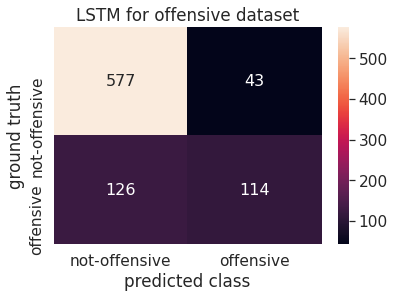

In [ ]:
print("LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 8s 46ms/step - loss: 0.6377 - acc: 0.6564 - val_loss: 0.6060 - val_acc: 0.6586
Epoch 2/5
94/94 [==============================] - 3s 36ms/step - loss: 0.5523 - acc: 0.7129 - val_loss: 0.5587 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 936 ms, sys: 19.1 ms, total: 955 ms
Wall time: 839 ms


BiLSTM:
Accuracy Score: 0.8
Macro F1 Score: 0.7061604595911037
Clasification report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87       620
           1       0.75      0.42      0.54       240

    accuracy                           0.80       860
   macro avg       0.78      0.68      0.71       860
weighted avg       0.79      0.80      0.78       860



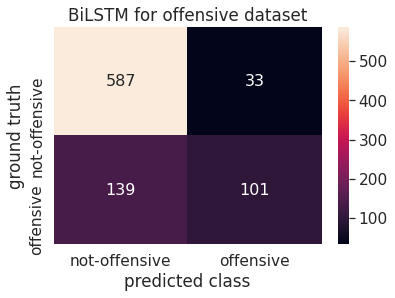

In [ ]:
print("BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 120,993
Trainable params: 120,993
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.42 s, sys: 41.9 ms, total: 1.46 s
Wall time: 1.3 s


Hierarchical LSTM:
Accuracy Score: 0.8011627906976744
Macro F1 Score: 0.7061614972856003
Clasification report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87       620
           1       0.76      0.42      0.54       240

    accuracy                           0.80       860
   macro avg       0.79      0.68      0.71       860
weighted avg       0.80      0.80      0.78       860



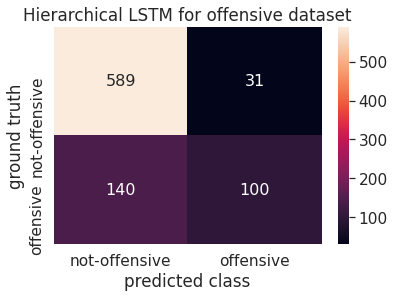

In [ ]:
print("Hierarchical LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 162,369
Trainable params: 162,369
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 2.8 s, sys: 47.7 ms, total: 2.85 s
Wall time: 2.45 s


Hierarchical BiLSTM:
Accuracy Score: 0.8034883720930233
Macro F1 Score: 0.7161721714371639
Clasification report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       620
           1       0.75      0.45      0.56       240

    accuracy                           0.80       860
   macro avg       0.78      0.69      0.72       860
weighted avg       0.80      0.80      0.79       860



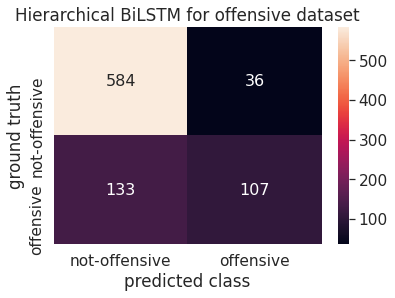

In [ ]:
print("Hierarchical BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiGRU is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(GRU(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiGRU Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
94/94 [==============================] - 9s 45ms/step - loss: 0.6371 - acc: 0.6599 - val_loss: 0.5729 - val_acc: 0.7054
Epoch 2/5
94/94 [==============================] - 3s 36ms/step - loss: 0.5192 - acc: 0.7486 - val_loss: 0.5446 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 919 ms, sys: 22 ms, total: 941 ms
Wall time: 816 ms


BiGRU:
Accuracy Score: 0.7988372093023256
Macro F1 Score: 0.7362239135946274
Clasification report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       620
           1       0.67      0.56      0.61       240

    accuracy                           0.80       860
   macro avg       0.75      0.73      0.74       860
weighted avg       0.79      0.80      0.79       860



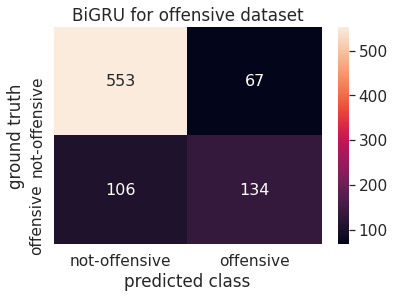

In [ ]:
print("BiGRU:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiGRU for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
%%time
# RoBERTa is used as the classification model
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

#golden_label = [i[1] for i in test_set]
tested_label = []
for i in range(len(test_text)):
  text = test_text[i]
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  tested_label.append(np.argmax(scores))


CPU times: user 3min 35s, sys: 5.72 s, total: 3min 41s
Wall time: 3min 44s


RoBERTa:
Accuracy Score: 0.8558139534883721
Macro F1 Score: 0.8112152047529015
Clasification report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       620
           1       0.79      0.66      0.72       240

    accuracy                           0.86       860
   macro avg       0.83      0.80      0.81       860
weighted avg       0.85      0.86      0.85       860



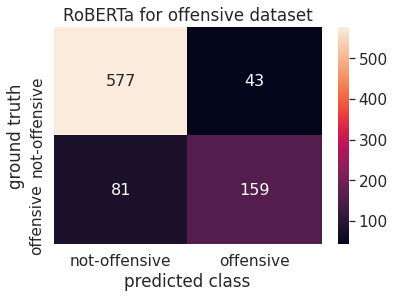

In [ ]:
print("RoBERTa:")
accuracy = metrics.accuracy_score(test_set_label, tested_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, tested_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, tested_label))

cm = confusion_matrix(test_set_label, tested_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"RoBERTa for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()